## install and import

In [ ]:
#install xgboost
!pip install xgboost

In [ ]:
!pip install lightgbm

In [ ]:
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=58f5e3225017ba1982733b687f9bc4110b44b92361b73e3d775f4c1b24bb4f6f
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
#===== Set Up Library =====
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.model_selection import GridSearchCV

### Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/tugas dibimbing/extra class 5 essambling/Train.csv')
data.head(3)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1


Dictionary :

The dataset used for model building contained 10999 observations of 12 variables.
The data contains the following information:

* ID: ID Number of Customers.
* Warehouse block: The Company have big Warehouse which is divided in to block such as A,B,C,D,E.
* Mode of shipment:The Company Ships the products in multiple way such as Ship, Flight and Road.
* Customer care calls: The number of calls made from enquiry for enquiry of the shipment.
* Customer rating: The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best).
* Cost of the product: Cost of the Product in US Dollars.
* Prior purchases: The Number of Prior Purchase.
* Product importance: The company has categorized the product in the various parameter such as low, medium, high.
* Gender: Male and Female.
* Discount offered: Discount offered on that specific product.
* Weight in gms: It is the weight in grams.
* Reached on time: It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


### Target Distribution

In [ ]:
data['Reached.on.Time_Y.N'].value_counts()

1    6563
0    4436
Name: Reached.on.Time_Y.N, dtype: int64

In [ ]:
data['Reached.on.Time_Y.N'].value_counts(normalize=True)*100

1    59.669061
0    40.330939
Name: Reached.on.Time_Y.N, dtype: float64

### Drop unused feature

In [ ]:
data = data.drop(['ID'], axis=1)

### Feature vs Target Correlation

<Axes: >

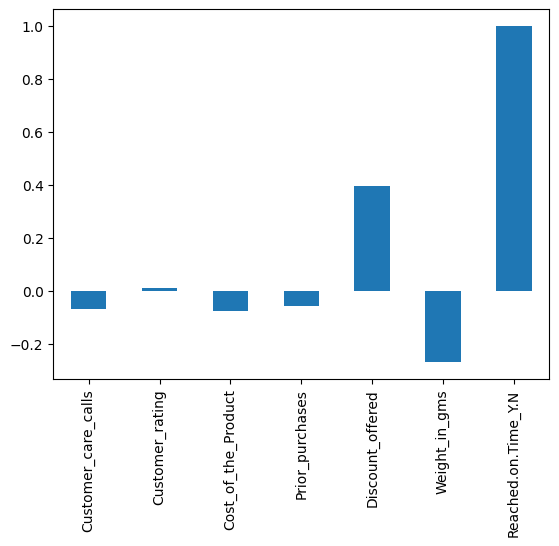

In [ ]:
data.corr()['Reached.on.Time_Y.N'].plot(kind='bar')

## Simple Data Preparation

### Drop duplicates

In [ ]:
data.duplicated().sum()

0

In [ ]:
data = data.drop_duplicates()

### Drop missing value

In [ ]:
data.isnull().sum()

Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [ ]:
data = data.dropna().reset_index(drop=True)

### User numeric only

In [ ]:
data_temp = data.select_dtypes(include=np.number)
data_temp.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,4,2,177,3,44,1233,1
1,4,5,216,2,59,3088,1
2,2,2,183,4,48,3374,1
3,3,3,176,4,10,1177,1
4,2,2,184,3,46,2484,1


In [ ]:
data.shape

(10999, 11)

### Target Distribution

In [ ]:
data['Reached.on.Time_Y.N'].value_counts(normalize=True)*100

1    59.669061
0    40.330939
Name: Reached.on.Time_Y.N, dtype: float64

### Split Train and Test

In [ ]:
X = data_temp.drop('Reached.on.Time_Y.N', axis=1)
y = data_temp[['Reached.on.Time_Y.N']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Modeling and Evaluation

In [ ]:
list_model = [
    RandomForestClassifier(random_state=42),
    XGBClassifier(random_state=42),
    LGBMClassifier(random_state=42),
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42)
]

df = pd.DataFrame(columns=['Method', 'Precision Train', 'Precision Test','Recall Train','Recall Test','Classification Report'])

for model in list_model:
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    method = str(type(model)).split('.')[-1][:-2]

    precision_train = precision_score(y_train, y_train_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_train = recall_score(y_train, y_train_pred)
    recall_test = recall_score(y_test, y_test_pred)
    c_report = classification_report(y_test, y_test_pred, digits=4)

    df = df.append({'Method': method,
                    'Precision Train': precision_train,
                    'Precision Test': precision_test,
                    'Recall Train': recall_train,
                    'Recall Test': recall_test,
                    'Classification Report': c_report},
                    ignore_index=True)

[LightGBM] [Info] Number of positive: 5258, number of negative: 3541
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 8799, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.597568 -> initscore=0.395342
[LightGBM] [Info] Start training from score 0.395342


In [ ]:
df

,Method,Precision Train,Precision Test,Recall Train,Recall Test,Classification Report
0,RandomForestClassifier,1.000000,0.751767,1.000000,0.652107,precision recall f1-score ...
1,XGBClassifier,0.941594,0.729043,0.858501,0.659770,precision recall f1-score ...
2,LGBMClassifier,0.929804,0.775432,0.758273,0.619157,precision recall f1-score ...
3,LogisticRegression,0.705156,0.694902,0.673640,0.678927,precision recall f1-score ...
4,DecisionTreeClassifier,1.000000,0.697761,1.000000,0.716475,precision recall f1-score ...


In [ ]:
model = LogisticRegression(random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.5470    0.5654    0.5560       895
           1     0.6949    0.6789    0.6868      1305

    accuracy                         0.6327      2200
   macro avg     0.6210    0.6221    0.6214      2200
weighted avg     0.6347    0.6327    0.6336      2200



In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.5749    0.6860    0.6256       895
           1     0.7518    0.6521    0.6984      1305

    accuracy                         0.6659      2200
   macro avg     0.6633    0.6691    0.6620      2200
weighted avg     0.6798    0.6659    0.6688      2200



In [ ]:
model = XGBClassifier(random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.5643    0.6425    0.6008       895
           1     0.7290    0.6598    0.6927      1305

    accuracy                         0.6527      2200
   macro avg     0.6467    0.6511    0.6468      2200
weighted avg     0.6620    0.6527    0.6553      2200



In [ ]:
model = LGBMClassifier(random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

[LightGBM] [Info] Number of positive: 5258, number of negative: 3541
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 8799, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.597568 -> initscore=0.395342
[LightGBM] [Info] Start training from score 0.395342
              precision    recall  f1-score   support

           0     0.5708    0.7385    0.6439       895
           1     0.7754    0.6192    0.6885      1305

    accuracy                         0.6677      2200
   macro avg     0.6731    0.6789    0.6662      2200
weighted avg     0.6922    0.6677    0.6704      2200



In [ ]:
#Save the dataframe to a CSV file
df.to_csv('/content/drive/MyDrive/Fortofolio Data Science/Classification of Estimated Delivery/The Baseline models.csv', index=False)